# **Introduction**

- In this notebook, we use the initially cleaned eviction data and turn it into geodataframe. From cleaning_eviction notebook, we have known the evictions during and outside of covid behave drastically differently, therefore, in this notebook, we first break the initial cleaned_eviction df into 2 parts: covid and pre-post covid, and then analyze their stats.

- For clarity and brevity, we only focus on normal times in this notebook.

- In order to analyze the building per year eviction data, we aggregate and merge based on bbl and create the new column "average_year_eviction_count", representing avegrae evictions per year per building. For each dataframe, we visualize the trends over the years in aggregated data and per building per year data, with stats summary. We also visualize the eviction distributions in nyc with plotly and folium on maps. To make the visuals more clear, we create different maps with different thresholds.  

- Finally, we find the buildings with the most evictions (> 10 or >5) on each period. We will use these bbl and merge them with BBL.csv to find the exact buildings and locate the landlords. Further analysis will continue in the same series notebooks until clustering analysis and getting to know the data is done.

- All charts, summaries, maps can be found in images folder.

In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

import matplotlib.pyplot as plt

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

In [4]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_row', 1000)

# **Part 1 Get the Eviction data**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data source:
file_path = '/content/drive/My Drive/X999/evictions_df_cleaned.csv'

In [7]:
evictions_df_raw = pd.read_csv(file_path)

In [8]:
evictions_df = evictions_df_raw.copy()

In [9]:
evictions_df.bin = evictions_df.bin.astype(int)
evictions_df.bbl = evictions_df.bbl.astype(int)

In [10]:
evictions_df.shape
# correct

(83282, 20)

In [11]:
evictions_df.head(2)

,primary_key,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,year,month_year
0,*308072/22_5865,*308072/22,5865,356 MILLER AVE,1 AND BASEMENT,2024-12-04,BROOKLYN,11207,Not an Ejectment,Possession,40.672121,-73.891105,5.0,37.0,1152.0,3083989,3037420029,East New York,2024,2024-12
1,*313639/23_5202,*313639/23,5202,710 61ST STREET,2ND FLOOR,2024-03-04,BROOKLYN,11220,Not an Ejectment,Possession,40.635941,-74.011883,7.0,38.0,118.0,3143881,3057940012,Sunset Park East,2024,2024-03


In [12]:
evictions_df.columns, \
evictions_df.shape

(Index(['primary_key', 'court_index_number', 'docket_number',
        'eviction_address', 'eviction_apartment_number', 'executed_date',
        'borough', 'eviction_postcode', 'ejectment',
        'eviction/legal_possession', 'latitude', 'longitude', 'community_board',
        'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year',
        'month_year'],
       dtype='object'),
 (83282, 20))

In [13]:
evictions_df.executed_date = pd.to_datetime(evictions_df.executed_date)

In [14]:
evictions_df.executed_date.min(), evictions_df.executed_date.max()

(Timestamp('2017-01-03 00:00:00'), Timestamp('2024-12-30 00:00:00'))

# **Part 2 Convert the dataframe to geopanda**

#### To properly understand the geo features and find hot spots in this evcition datasets, we need to utilize the GeoDataFrame to see if there is any interesting patterns that could be attributed to Societal trends/Predatory landlord bahaviors/corporate landlord behaviors

In [15]:
# first, we create a GeoDataFrame
# when we save them in 2 different periods, they will also be geopanda
evictions_gdf = gpd.GeoDataFrame(
    evictions_df,
    geometry=gpd.points_from_xy(evictions_df['longitude'], evictions_df['latitude']))

In [16]:
evictions_gdf.shape, evictions_gdf.columns

((83282, 21),
 Index(['primary_key', 'court_index_number', 'docket_number',
        'eviction_address', 'eviction_apartment_number', 'executed_date',
        'borough', 'eviction_postcode', 'ejectment',
        'eviction/legal_possession', 'latitude', 'longitude', 'community_board',
        'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year',
        'month_year', 'geometry'],
       dtype='object'))

In [17]:
evictions_cleaned = evictions_gdf.dropna(subset=['latitude', 'longitude'])
evictions_cleaned = evictions_cleaned.reset_index(drop=True)

In [18]:
# type(evictions_cleaned)
# it's geo dataframe, the explaination is too long, therefore commented out.

In [19]:
evictions_cleaned.columns

Index(['primary_key', 'court_index_number', 'docket_number',
       'eviction_address', 'eviction_apartment_number', 'executed_date',
       'borough', 'eviction_postcode', 'ejectment',
       'eviction/legal_possession', 'latitude', 'longitude', 'community_board',
       'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year',
       'month_year', 'geometry'],
      dtype='object')

# **Part 3: seperate the periods**
## **A note before we do the groupby and why we seperate the periods first**:
### We need to seperate the two periods, normal times and covid, before we aggregate and merge the average_eviction_count per building, because in these two periods, the severity of the evictions were very different.

In [20]:
# here is why
evictions_per_year = evictions_cleaned.groupby('year').size().reset_index(name='eviction_count')
evictions_per_year = evictions_per_year.sort_values('year')
evictions_per_year

,year,eviction_count
0,2017,18528
1,2018,17763
2,2019,15180
3,2020,2707
4,2021,126
5,2022,3731
6,2023,11163
7,2024,14084


## **Let's break this geopanda with avegrae eviction count per building into two periods**

In [21]:
evictions_cleaned['year'] = evictions_cleaned['executed_date'].dt.year
pre_post_covid_years = [2017, 2018, 2019, 2023, 2024]
covid_years = [2020, 2021, 2022]

In [22]:
evictions_pre_post_covid = evictions_cleaned[evictions_cleaned['year'].isin(pre_post_covid_years)].copy()
evictions_covid = evictions_cleaned[evictions_cleaned['year'].isin(covid_years)].copy()

In [23]:
evictions_pre_post_covid.columns

Index(['primary_key', 'court_index_number', 'docket_number',
       'eviction_address', 'eviction_apartment_number', 'executed_date',
       'borough', 'eviction_postcode', 'ejectment',
       'eviction/legal_possession', 'latitude', 'longitude', 'community_board',
       'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year',
       'month_year', 'geometry'],
      dtype='object')

In [24]:
len(evictions_pre_post_covid), \
len(evictions_covid), \
76718 + 6564
# correct

(76718, 6564, 83282)

In [25]:
type(evictions_pre_post_covid), type(evictions_covid)
# geodataframe

(geopandas.geodataframe.GeoDataFrame, geopandas.geodataframe.GeoDataFrame)

## **Now, we have 2 dataframes, one is post/pre covid and we have their average evictions per building, per year. The other one is covid and we also have their average evictions per building per year. These two columns' (from 2 dataframes) numbers are very different**

In [26]:
evictions_pre_post_covid.columns == evictions_cleaned.columns, \
evictions_covid.columns == evictions_cleaned.columns
# check if merge was correct

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]))

In [27]:
evictions_pre_post_covid.shape, \
evictions_covid.shape, \
76718 + 6564, \
76718/5, 6564/3

((76718, 21), (6564, 21), 83282, 15343.6, 2188.0)

In [28]:
# temporarily save cleaned covid evictions data to my drive
# we will work on this in a seperate file for clarity
evictions_covid.to_csv('/content/drive/My Drive/X999/evictions_covid.csv', index=False)

# **From now on, everything is about normal times**

# **Part 4: Aggregation to find eviction counts (with BIN)**

#### Aggregate by bin:

BIN (buiding identification numbers) appears to be the most sensible basic unit here, as other ones: apartment unit, neighborhood, zipcode, and borough would either be too small (non-representable) or too large to understand landlord behaviors.

## **A tiny note on groupby and merge:**
### One tricky thing is when we do the groupby and merge to calcuate per building per year's eviction, we're finding one average evictions per year value for each unique building. When we merge this value back to the original df, we want all rows that have the same bin get the same avg_evictions_per_building value. If we groupby 'bin', 'year', and have the numb_years, each bin will be divided by different number of years (the number of years that they had evictions), and therefore it is different from groupby bin and directly divide by 5.
### This is a big distinction, because groupby bin and year, and divide by the years each building had eviction assumes that when the building did not have evictions that year, the buildings did not exist. This is not true. We need to treat as if all the buildings exist in all these years.
### Since bbl data has a cutoff at 2020 (something we learned from another dataset), we will not go into details to think about "what if certain buildings were completed in 2019 and did not exist in 2017" this type of questions.

In [29]:
# evictions_by_building_year = evictions_df.groupby(['bin', 'year']).size().reset_index(name='evictions')
# years_per_building = evictions_by_building_year.groupby('bin')['year'].nunique()
# total_evictions = evictions_by_building_year.groupby('bin')['evictions'].sum()
# avg_evictions = total_evictions / years_per_building
# # don't do this

In [30]:
# groupby
evictions_per_building = evictions_pre_post_covid.groupby('bin').size().reset_index(name='total_evictions')

In [31]:
# divide by all years covered
evictions_per_building['average_year_eviction_count'] = evictions_per_building['total_evictions'] / 5

In [32]:
# merge the average_year_eviction_count back to the evictions_df based on bin
evictions_pre_post_covid = evictions_pre_post_covid.merge(evictions_per_building[['bin', 'average_year_eviction_count']], on='bin', how='left')

In [33]:
evictions_pre_post_covid.shape, len(evictions_pre_post_covid.bin.unique())

((76718, 22), 36029)

In [34]:
evictions_pre_post_covid.head()

,primary_key,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,...,community_board,council_district,census_tract,bin,bbl,nta,year,month_year,geometry,average_year_eviction_count
0,*308072/22_5865,*308072/22,5865,356 MILLER AVE,1 AND BASEMENT,2024-12-04,BROOKLYN,11207,Not an Ejectment,Possession,...,5.0,37.0,1152.0,3083989,3037420029,East New York,2024,2024-12,POINT (-73.8911 40.67212),0.8
1,*313639/23_5202,*313639/23,5202,710 61ST STREET,2ND FLOOR,2024-03-04,BROOKLYN,11220,Not an Ejectment,Possession,...,7.0,38.0,118.0,3143881,3057940012,Sunset Park East,2024,2024-03,POINT (-74.01188 40.63594),0.6
2,*324973/22_5308,*324973/22,5308,462 60TH STREET,FOURTH FLOOR APT AKA,2024-08-13,BROOKLYN,11220,Not an Ejectment,Possession,...,7.0,38.0,122.0,3143435,3057820030,Sunset Park West,2024,2024-08,POINT (-74.01707 40.64001),0.6
3,*53336/16_170279,*53336/16,170279,3400 PAUL AVENUE,15D,2018-10-17,BRONX,10468,Not an Ejectment,Possession,...,7.0,11.0,409.0,2015444,2032510420,Van Cortlandt Village,2018,2018-10,POINT (-73.88957 40.87719),0.8
4,*5990/17_2703,*5990/17,2703,480 CONCORD AVENUE,4E,2019-08-30,BRONX,10455,Not an Ejectment,Possession,...,1.0,8.0,35.0,2003900,2025770038,Mott Haven-Port Morris,2019,2019-08,POINT (-73.90881 40.8112),1.6


In [35]:
evictions_per_building.shape
# correct 38502

(36029, 3)

In [36]:
# evictions_cleaned.to_csv('/content/drive/My Drive/X999/evictions_geo_cleaned_all.csv', index=False)

**During normal years, on average, each year has about 15343.6 evictions, but during covid 3 years, each year only has 2188 evictions.**

Here is a breakdown of each year:

In [37]:
# evictions_per_year = evictions_pre_post_covid.groupby('year').size().reset_index(name='eviction_count')
# evictions_per_year = evictions_pre_post_covid.sort_values('year')
# evictions_per_year.head()

In [38]:
# average_per_year = evictions_per_year['eviction_count'].mean()
# average_per_year

In [39]:
# evictions_pre_post_covid.columns == evictions_covid.columns

# **Part 5 Eviction trends over time and over different buildings**

## **Only normal times in this file**

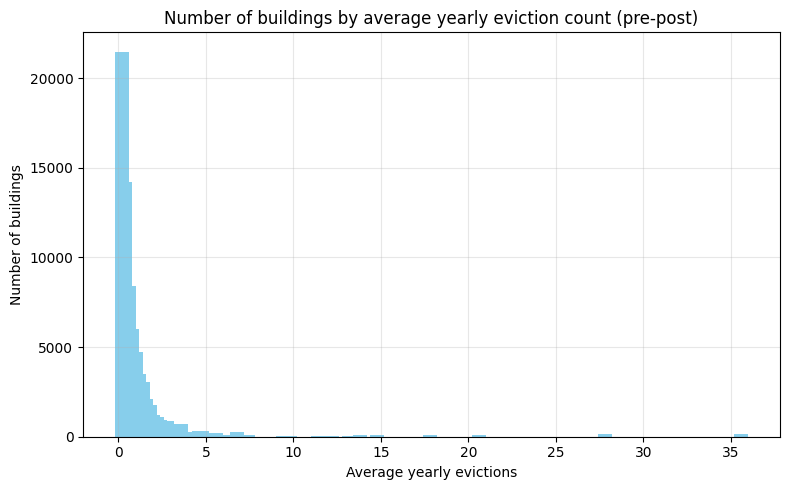

In [40]:
eviction_counts = evictions_pre_post_covid['average_year_eviction_count'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(eviction_counts.index, eviction_counts.values, color='skyblue')

plt.title('Number of buildings by average yearly eviction count (pre-post)', fontsize=12)
plt.xlabel('Average yearly evictions')
plt.ylabel('Number of buildings')

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# create stats
total_buildings = eviction_counts.sum()
buildings_one_eviction = eviction_counts.get(1.0, 0)
percentage_one_eviction = (buildings_one_eviction / total_buildings) * 100

In [41]:
# get the metrics first
most_common_count = eviction_counts.index[eviction_counts.argmax()]
buildings_less_equal_common = (evictions_per_building['average_year_eviction_count'] <= most_common_count).sum()
percentage_less_equal_common = (buildings_less_equal_common / total_buildings) * 100

In [42]:
most_common_count, buildings_less_equal_common, percentage_less_equal_common

(np.float64(0.2), np.int64(21479), np.float64(27.997340910868374))

In [43]:
summary_data = {'metrics': ['total buildings', 'most common eviction count (per building, per year)',
  'buildings with exactly one eviction per year', 'buildings with less than most common eviction count (per building, per year)'],
'value': [f"{total_buildings:,}", f"{most_common_count:.2f} ({eviction_counts.max():,} buildings)",
f"{buildings_one_eviction:,} ({percentage_one_eviction:.1f}%)",f"{buildings_less_equal_common:,} ({percentage_less_equal_common:.1f}%)"]}

summary_df = pd.DataFrame(summary_data)
summary_df

,metrics,value
0,total buildings,"76,718"
1,"most common eviction count (per building, per year)","0.20 (21,479 buildings)"
2,buildings with exactly one eviction per year,"4,720 (6.2%)"
3,"buildings with less than most common eviction count (per building, per year)","21,479 (28.0%)"


In [44]:
evictions_pre_post_covid['average_year_eviction_count'].mean()

np.float64(1.24063192471128)

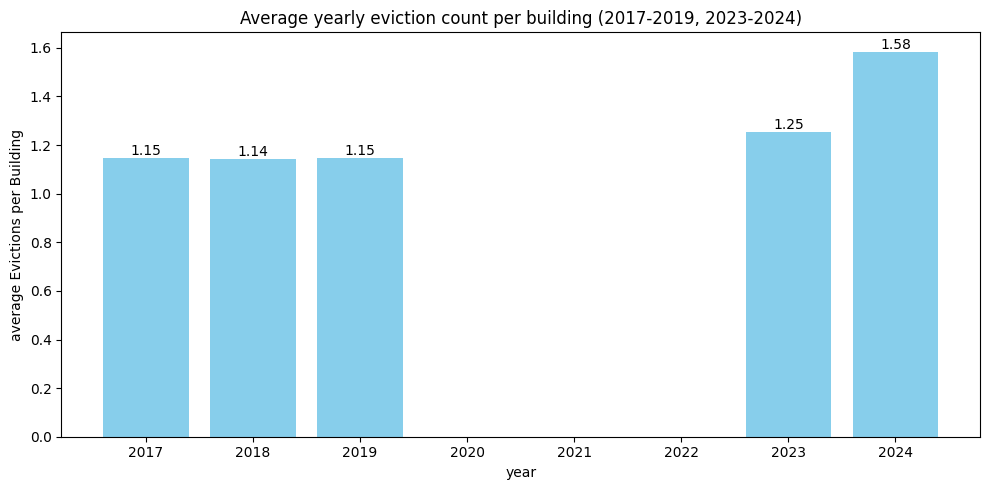

In [45]:
yearly_means = evictions_pre_post_covid.groupby('year')['average_year_eviction_count'].mean()

plt.figure(figsize=(10, 5))
bars = plt.bar(yearly_means.index, yearly_means.values, color='skyblue')

plt.title('Average yearly eviction count per building (2017-2019, 2023-2024)', fontsize=12)
plt.xlabel('year')
plt.ylabel('average Evictions per Building')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [46]:
combined_stats = {
    'metric': ['overall mean', f'maximum average ({yearly_means.idxmax()})',
        f'minimum average ({yearly_means.idxmin()})'] + [f"average for {year}" for year in yearly_means.index],
    'value': [f"{yearly_means.mean():.2f}",
  f"{yearly_means.max():.2f}",f"{yearly_means.min():.2f}"] + [f"{avg:.2f}" for avg in yearly_means.values]}

In [47]:
combined_df = pd.DataFrame(combined_stats)
combined_df

,metric,value
0,overall mean,1.25
1,maximum average (2024),1.58
2,minimum average (2018),1.14
3,average for 2017,1.15
4,average for 2018,1.14
5,average for 2019,1.15
6,average for 2023,1.25
7,average for 2024,1.58


# **Part 6 Visualize the GeoDataFrame -- Plotly and Folium**

## **Part 6.1 Plotly first pre-post covid**

Did not show the pre-view here to save space, but we will add the results to the image folder.


In [8]:
# scatter map showing eviction counts by bin
# a very basic and high-level visualization of each building's annual eviction during the year pre and post covid
# the outlines are clear. They are the lighter and orange ones.
fig = px.scatter_geo(evictions_pre_post_covid,
                     lat='latitude', lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bin',
                     title="Evictions by bin in NYC pre-post")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [9]:
# not let the ones < 5 shown
evictions_filtered = evictions_pre_post_covid[evictions_pre_post_covid['average_year_eviction_count'] >= 5]
fig = px.scatter_geo(evictions_filtered,
                     lat='latitude',
                     lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bin',
                     title="Evictions by bin in NYC (5+ Evictions) pre-post")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [10]:
# not let the ones < 10 shown
evictions_filtered = evictions_pre_post_covid[evictions_pre_post_covid['average_year_eviction_count'] >= 10]
fig = px.scatter_geo(evictions_filtered,
                     lat='latitude',
                     lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bin',
                     title="Evictions by bin in NYC (10+ Evictions) pre-post")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [51]:
# # in case the graph does not load, it is as shown below
# # it is originally an interactive graph where if you point to a building, you get the bin id, laititude, longitude, and
# # the annual eviction counts
# from google.colab import files
# from IPython.display import Image
# uploaded = files.upload()
# Image(filename='plotly_image.png')

In [52]:
# # save as an interactive HTML file
# pio.write_html(fig, file='evictions_map.html', auto_open=False)

#### Short summaries:  
- During covid, buildings with high evictions were drastically fewer than normal times. And the buildings with high evictions were consistent with the normal times'.[link text](https://)


## **Part 6.2 Folium pre-post covid**

In [11]:
# use folium heatmap to show the data in a better visualization
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap pre post covid (all buildings with evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))
heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']] for index, row in evictions_pre_post_covid.iterrows()]
HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

In [12]:
# not let the ones < 5 shown
evictions_filtered = evictions_pre_post_covid[evictions_pre_post_covid['average_year_eviction_count'] >= 5]

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
# html
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap pre post covid (5+ Evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))
heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']]
             for index, row in evictions_filtered.iterrows()]

HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

In [13]:
# not let the ones < 10 shown
evictions_filtered = evictions_pre_post_covid[evictions_pre_post_covid['average_year_eviction_count'] >= 10]

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
# HTML
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap pre post covid (10+ Evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))

heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']]
             for index, row in evictions_filtered.iterrows()]

HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

In [56]:
# # in case it does not load, it is as shown below
# from google.colab import files
# from IPython.display import Image
# uploaded = files.upload()
# Image(filename='heat_map.png')

#### Short summaries:
- Based on the analysis of NYC eviction data in two periods (covid in another file), there's a clear distinction between eviction patterns during and outside of the covid period. In the pre/post covid years (2017-2019, 2023-2024), evictions had a higher rate, with more buildings affected and a much higher average number of evictions per building (0.3 vs 1.24 on average per building, per year). During the Covid period (2020-2022), there was a significant decrease in eviction activity, likely due to eviction moratoriums and other protective measures implemented during the pandemic, and a decrease in rents with many residents fleeing NYC. This is interesting, as it is consistent with the phenomenon that lower rents environment overall actually encourages evictions.

- In both periods, the majority of buildings experienced just one eviction per year, suggesting that most landlords use eviction as an occasional rather than frequent measure. However, there were some properties with notably higher eviction counts, particularly in the normal years. These concentrated areas also tend to be the regular buildings and neighborhoods who show persistent behaviors over the years.

- Foliums shows clear geo relationships with the NYC background. Plotly shows the drastic change with less background distractions.

- TBC

# **Part 7 Buildings with high evictions in normal times**

In [57]:
# evictions_cleaned.columns
## didn't change

In [58]:
len(evictions_pre_post_covid.bin.unique()), \
len(evictions_covid.bin.unique())

(36029, 5326)

In [59]:
evictions_pre_post_covid.bin.dtype

dtype('int64')

In [60]:
# sort by eviction_count and extract the top 10 records based on the average_year_eviction_count column
top_bins_pre_post = evictions_pre_post_covid[['bin', 'average_year_eviction_count']].groupby('bin').mean().sort_values(by='average_year_eviction_count', ascending=False)
top_bins_pre_post.shape

(36029, 1)

In [61]:
top_bins_pre_post.head(20)

,average_year_eviction_count
bin,
3000000,35.6
2000000,27.8
4298968,20.6
4000000,17.8
2127134,14.8
1000000,13.8
2113629,13.4
3326600,13.2
2093973,12.2


In [62]:
bins_over_10_evictions = top_bins_pre_post[top_bins_pre_post['average_year_eviction_count'] > 10]
bins_over_10_evictions.shape
# 18 buildings have eviction counts larger than 10 per year on average

(10, 1)

In [63]:
bins_over_10_evictions

,average_year_eviction_count
bin,
3000000,35.6
2000000,27.8
4298968,20.6
4000000,17.8
2127134,14.8
1000000,13.8
2113629,13.4
3326600,13.2
2093973,12.2


### TODO:
### Some potential research questions/hypothesis include:
    - look into each of these buildings and check who the landlords are. (with the merge of BBL)
    - are they individual landlord or corporate landlords?
    - do they habitually exbihit such behavior?
    - is there a reason for the evictions besides the tenants' behavior?
    - is this related to building policy changes?
    - is this related to city-wide/neighborhood-wide changes?
### Another dataset we will be using: BBL.csv
    - pull the info of the buildings from bbl
    - since there are only 18 of them, we can have a closer look at them and then get a writeup of the landlords' background.

#### The rest of the analysis will be broken down into different notebooks

In [64]:
# save cleaned evictions data to my drive
evictions_pre_post_covid.to_csv('/content/drive/My Drive/X999/evictions_pre_post_covid.csv', index=False)

In [65]:
# save cleaned evictions data to my drive
evictions_covid.to_csv('/content/drive/My Drive/X999/evictions_covid.csv', index=False)